In [38]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
import numpy as np
from unidecode import unidecode
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('riderlistcsv.csv')
df.head()

,type,Points,Name,url_fix
0,All Rounder,26,Remco Evenepoel,NaN
1,All Rounder,24,Primož Roglič,NaN
2,All Rounder,18,Geraint Thomas,NaN
3,All Rounder,16,João Almeida,NaN
4,All Rounder,14,Aleksandr Vlasov,NaN


In [40]:
"""Get ready to scrape the data- format the names"""
# define a function to remove accents
def remove_accents(text):
    return unidecode(text)

#Remove accents
df['Name_clean'] = df['Name'].apply(remove_accents)
#Remove trailing spaces
df['Name_clean'] = df['Name_clean'].str.strip()
# replace spaces with a dash in the Name column
df['Name_clean'] = df['Name_clean'].str.replace(' ', '-')
df.head()


,type,Points,Name,url_fix,Name_clean
0,All Rounder,26,Remco Evenepoel,NaN,Remco-Evenepoel
1,All Rounder,24,Primož Roglič,NaN,Primoz-Roglic
2,All Rounder,18,Geraint Thomas,NaN,Geraint-Thomas
3,All Rounder,16,João Almeida,NaN,Joao-Almeida
4,All Rounder,14,Aleksandr Vlasov,NaN,Aleksandr-Vlasov


In [41]:
""" Scrape points data from PCS """
#Choose whether to scrape:
collect = 0

if collect:
    for index, row in df.iterrows():
        if pd.isnull(row['url_fix']):
            urlname = row['Name_clean']
            url = f"http://www.procyclingstats.com/rider/{urlname}"
        else:
            url = row['url_fix']
            
            
        print(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        rdr_info_find = soup.find_all('div', class_='rdr-info-cont')
        text = rdr_info_find[0].text

        #Extract additional stats
        try:
            age = re.findall(r'Date of birth:.*?\((\d+)\)', text)[0]
            weight = re.findall(r'Weight: (\d+) kg', text)[0]
            height = re.findall(r'Height: (\d+\.\d+) m', text)[0]
            oneday = re.findall(r"Points per specialty(\d+)", text)[0]
            GC = re.findall(r"One day races(\d+)", text)[0]
            TT = re.findall(r"GC(\d+)", text)[0]
            sprint = re.findall(r"Time trial(\d+)", text)[0]
            climber = re.findall(r"Sprint(\d+)", text)[0]
            
            #Store all of these stats 
            var_store = {'dob':age,'weight':weight,'height':height,'oneday':oneday,'GC':oneday,'TT':TT,'sprint':sprint,'climber':climber}
            for var_add in var_store:
                df.loc[index,var_add] = var_store[var_add]
                print(var_store[var_add])
        except:
            print("Issue with rider stats")    
            
        #Find points per year 
        my_spans = soup.find_all('table', class_='basic rdr-season-stats')

        for select_span in my_spans:
            
            rows_find = select_span.find_all('tr')
            #print(rows_find)
            for idx, row_ht in enumerate(rows_find):
                if idx == 0:
                    continue
                #print(row_ht)
                cols = row_ht.find_all('td')
                #print(cols)
                year = cols[0].text.strip()
                score = cols[1].find('span').text.strip()
                #print(f'Year: {year}, Score: {score}')
                row[year] = score
                df.loc[index,year] = score
        
    df.to_csv('saved_scrape_new.csv')

else:
    df = pd.read_csv('saved_scrape.csv')

In [42]:
#Convert scraped string to numeric
dfa = df
cols = list(df.columns)
string_cols = ['type','Name']
cols_to_convert = [col for col in cols if col not in string_cols]
dfa[cols_to_convert] = dfa[cols_to_convert].apply(pd.to_numeric, errors='coerce')
dfa.head()


,Unnamed: 0,type,Points,Name,url_fix,Name_clean,dob,weight,height,oneday,...,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,0,All Rounder,26,Remco Evenepoel,NaN,NaN,23.0,61.0,1.71,1889.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,All Rounder,24,Primož Roglič,NaN,NaN,33.0,65.0,1.77,1537.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,All Rounder,18,Geraint Thomas,NaN,NaN,36.0,71.0,1.83,1236.0,...,565.0,308.0,55.0,36.0,32.0,43.0,2.0,NaN,NaN,NaN
3,3,All Rounder,16,João Almeida,NaN,NaN,24.0,63.0,1.78,396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,All Rounder,14,Aleksandr Vlasov,NaN,NaN,27.0,68.0,1.86,918.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 Ranked best based on the SPC_cur metric:
       SPC_cur   SPC_past3                 Name
17  765.166158  774.722053       Damiano Caruso
64  255.456416   90.763250            Ben Healy
36  161.695490   92.831830        Filippo Ganna
31  127.928723   64.865130  Einer Augusto Rubio
71  122.715327   52.905109      Henok Mulubrhan

 Ranked best based on the SPC_past3 metric:
       SPC_cur   SPC_past3            Name
17  765.166158  774.722053  Damiano Caruso
40  120.309144  140.311381     Stefan Küng
80  119.908114  111.524927    Lorenzo Rota
11   97.149634  101.049878    Diego Ulissi
29  113.892657   94.519774  Patrick Konrad


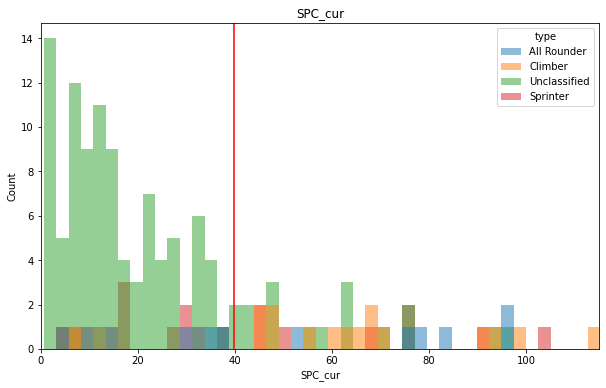

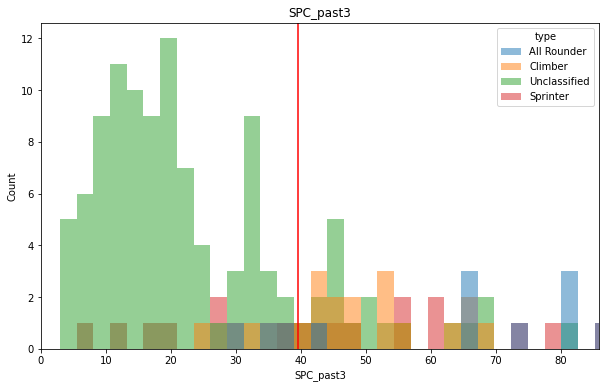

In [43]:
#Define valuation metrics and plot histogram
scale_factor = df['2022'].mean()/df['2023'].mean()
dfa['2023_scaled'] = dfa['2023']*scale_factor

dfa['SPC_cur'] = dfa['2023_scaled']/dfa['Points'].round(2)
dfa['SPC_past3'] = (dfa['2023_scaled']+dfa['2022']+dfa['2021'])/(3*dfa['Points']).round(2)

for score_metric in ('SPC_cur','SPC_past3'):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=dfa, x=score_metric,bins =300, hue='type', stat='count', edgecolor=None)
    ax.set_title(score_metric)
    ax.set_xlim(0,dfa[score_metric].quantile(0.95))
    ax.axvline(x = dfa[score_metric].mean(), color = 'r')
    print(f'\n Ranked best based on the {score_metric} metric:')
    print(dfa[['SPC_cur','SPC_past3','Name']].nlargest(5, score_metric))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

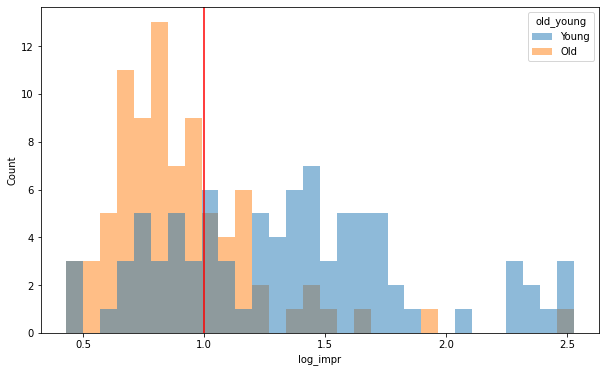

In [48]:
ylist = ['2023_scaled','2022','2021','2020','2019']
#Make a list of yearly improvements 
templist = list()
for i in range(0,len(ylist)-1):
    plt.figure()
    newname = f'impr_{ylist[i]}'
    templist.append(newname)
    dfa[newname] = dfa[ylist[i]]/dfa[ylist[i+1]]

#Average the improvements
dfa['mean_impr'] = dfa[templist].mean(axis=1)
dfa['log_impr'] = np.log(dfa['mean_impr'])

#Cap outliers
upper_pct = dfa['log_impr'].quantile(0.98)
dfa['log_impr'] = dfa['log_impr'].clip(upper=upper_pct)
lower_pct = dfa['log_impr'].quantile(0.02)
dfa['log_impr'] = dfa['log_impr'].clip(lower=lower_pct)

#Recenter at 1
dfa['log_impr'] = dfa['log_impr'] + 1
dfa['log_impr'] = dfa['log_impr']/dfa['log_impr'].median()

#Add a few more features
dfa['age_quantile'] = pd.qcut(dfa['dob'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
dfa['old_young'] = pd.qcut(dfa['dob'], q=2, labels=['Young', 'Old'])

#Plot improvements vs Age
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=dfa, x='log_impr',bins =30, hue='old_young', stat='count', edgecolor=None)
#ax.set_xlim(0,5)
ax.axvline(x = dfa['log_impr'].median(), color = 'r')

In [60]:
dfa['weight_PCS'] = dfa['SPC_past3']*dfa['log_impr'].round(2)
print('Avg. Improvement-weighted Cost  by Age quantile')
print(dfa.groupby('age_quantile')['weight_PCS'].mean())
dfa['age'] = dfa['dob'].round(0)

print('Avg. Improvement by Age quantile')
print(dfa.groupby('age_quantile')['log_impr'].mean())


Avg. Improvement-weighted Cost  by Age quantile
age_quantile
Q1    47.562049
Q2    41.467595
Q3    32.721431
Q4    56.160933
Name: weight_PCS, dtype: float64
Avg. Improvement by Age quantile
age_quantile
Q1    1.471677
Q2    1.231248
Q3    0.934575
Q4    0.865944
Name: log_impr, dtype: float64


In [61]:

df_disp = dfa[['Name','weight_PCS','type','age','Points','mean_impr']]

for type_name in df_disp['type'].unique():
    df_disp_cut = df_disp[df_disp['type'] == type_name]
    #print(df_disp_cut.nlargest(10, 'weight_PCS')
    tabplot = df_disp_cut.nlargest(10, 'weight_PCS')
    display(tabplot)

,Name,weight_PCS,type,age,Points,mean_impr
3,João Almeida,119.588626,All Rounder,24.0,16,2.783670
0,Remco Evenepoel,79.294138,All Rounder,23.0,26,1.378107
10,Bauke Mollema,73.493936,All Rounder,36.0,8,1.199377
4,Aleksandr Vlasov,66.623335,All Rounder,27.0,14,1.286527
7,Brandon McNulty,65.987806,All Rounder,25.0,10,1.460345
11,Diego Ulissi,65.682421,All Rounder,33.0,8,0.894611
1,Primož Roglič,59.559784,All Rounder,33.0,24,1.017170
5,Thymen Arensman,54.788137,All Rounder,23.0,12,2.816128
12,Rigoberto Urán,48.616046,All Rounder,36.0,8,1.000317
9,Bob Jungels,47.323615,All Rounder,30.0,8,3.436323


,Name,weight_PCS,type,age,Points,mean_impr
17,Damiano Caruso,728.238729,Climber,35.0,1,1.346243
21,Santiago Buitrago,116.716813,Climber,23.0,8,3.973937
27,Alessandro Covi,108.837171,Climber,24.0,6,3.513516
31,Einer Augusto Rubio,86.919274,Climber,25.0,6,2.321810
29,Patrick Konrad,75.615820,Climber,31.0,6,1.107953
22,Lorenzo Fortunato,70.074361,Climber,26.0,8,2.363504
19,Thibaut Pinot,66.099717,Climber,32.0,10,1.542173
33,Ilan Van Wilder,65.258926,Climber,22.0,6,2.302598
15,Jay Vine,61.119055,Climber,27.0,12,2.653067
18,Lennard Kämna,59.404111,Climber,26.0,10,2.810771


,Name,weight_PCS,type,age,Points,mean_impr
64,Ben Healy,205.124945,Unclassified,22.0,6,8.217424
80,Lorenzo Rota,120.446921,Unclassified,27.0,6,1.621209
40,Stefan Küng,112.249105,Unclassified,29.0,8,1.108201
42,Giovanni Aleotti,105.242456,Unclassified,23.0,6,8.193973
36,Filippo Ganna,104.899968,Unclassified,26.0,10,1.740405
74,Aurélien Paret-Peintre,90.086315,Unclassified,27.0,6,1.696088
87,Natnael Tesfatsion,89.953937,Unclassified,23.0,6,3.391328
154,Stephen Williams,83.350862,Unclassified,26.0,4,12.968179
71,Henok Mulubrhan,74.067153,Unclassified,23.0,6,2.510611
37,Magnus Cort,65.629615,Unclassified,30.0,8,1.455225


,Name,weight_PCS,type,age,Points,mean_impr
161,Mark Cavendish,201.766821,Sprinter,37.0,8,18.864193
174,Marius Mayrhofer,94.398172,Sprinter,22.0,6,27.512999
167,Vincenzo Albanese,92.286228,Sprinter,26.0,6,3.110922
157,Mads Pedersen,88.901520,Sprinter,27.0,14,1.426814
173,Arne Marit,67.098278,Sprinter,24.0,6,10.632474
168,Davide Ballerini,66.330485,Sprinter,28.0,6,1.268214
164,Kaden Groves,61.568214,Sprinter,24.0,8,2.247443
160,Michael Matthews,57.720188,Sprinter,32.0,10,0.923086
165,Max Kanter,46.386715,Sprinter,25.0,8,3.740689
172,Filippo Fiorelli,45.651207,Sprinter,NaN,6,1.719897


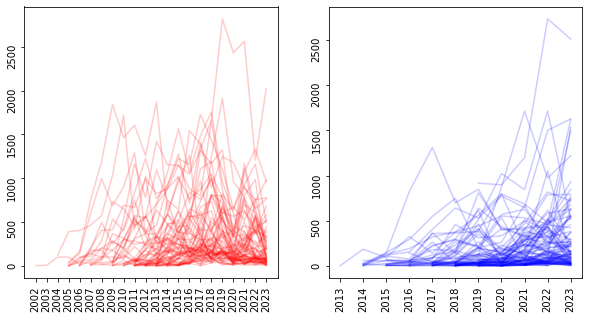

In [78]:
age_filter = dfa['age'] > 28
old_names = dfa.loc[age_filter, 'Name'].tolist()

dft = dfa.set_index('Name')
dft = dft.filter(regex='^20')
dft['2023'] = dft['2023_scaled']
dft = dft.drop(['2023_scaled'], axis=1)
dft = dft.transpose()
dft = dft.iloc[::-1, :]
df_colors = dfa.transpose()

fig, axs = plt.subplots(1,2, figsize = (10, 5))

for col in dft.columns:
    if col in old_names:
        cplot = 'r'
        axs[0].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[0].tick_params(rotation=90)
    else:
        cplot = 'b'
        axs[1].plot(dft[col], label=col,color=cplot,alpha=.2)
        axs[1].tick_params(rotation=90)
    
    #plt.xticks(rotation=90)



In [ ]:
print(dft)

Name  Remco Evenepoel  Primož Roglič   Geraint Thomas  João Almeida  \
2002              NaN            NaN              NaN           NaN   
2003              NaN            NaN              NaN           NaN   
2004              NaN            NaN              NaN           NaN   
2005              NaN            NaN              2.0           NaN   
2006              NaN            NaN             43.0           NaN   
2007              NaN            NaN             32.0           NaN   
2008              NaN            NaN             36.0           NaN   
2009              NaN            NaN             55.0           NaN   
2010              NaN            NaN            308.0           NaN   
2011              NaN            NaN            565.0           NaN   
2012              NaN            NaN            203.0           NaN   
2013              NaN            7.0            704.0           NaN   
2014              NaN          131.0            877.0           NaN   
2015  

In [ ]:
df_disp = df[['Name','value_current','value_past3','type']]
print(df_disp.nlargest(20, 'value_current'))



                       Name  value_current  value_past3          type
17           Damiano Caruso      10.701343    11.599231       Climber
64                Ben Healy       3.198606     0.187476  Unclassified
36            Filippo Ganna       1.818480     0.584350  Unclassified
71          Henok Mulubrhan       1.244707    -0.046745  Unclassified
40              Stefan Küng       1.209289     1.668434  Unclassified
80             Lorenzo Rota       1.203386     1.108094  Unclassified
157           Mads Pedersen       1.148572     0.698207      Sprinter
174        Marius Mayrhofer       0.973168    -0.280965      Sprinter
19            Thibaut Pinot       0.883442     0.254489       Climber
11             Diego Ulissi       0.868390     0.990170   All Rounder
52             Simon Clarke       0.866914     0.331695  Unclassified
0           Remco Evenepoel       0.859194     0.632395   All Rounder
74   Aurélien Paret-Peintre       0.831496     0.611459  Unclassified
13       Tao Geogheg

In [ ]:
print(df_disp.nlargest(30, 'value_past3'))

                       Name  value_current  value_past3          type
17           Damiano Caruso      10.701343    11.599231       Climber
40              Stefan Küng       1.209289     1.668434  Unclassified
80             Lorenzo Rota       1.203386     1.108094  Unclassified
11             Diego Ulissi       0.868390     0.990170   All Rounder
10            Bauke Mollema      -0.136599     0.945440   All Rounder
160        Michael Matthews       0.175080     0.878427      Sprinter
161          Mark Cavendish      -0.136599     0.834023      Sprinter
157           Mads Pedersen       1.148572     0.698207      Sprinter
3              João Almeida       0.560695     0.685195   All Rounder
4         Aleksandr Vlasov       -0.020226     0.676365   All Rounder
1             Primož Roglič       0.680969     0.637212   All Rounder
0           Remco Evenepoel       0.859194     0.632395   All Rounder
74   Aurélien Paret-Peintre       0.831496     0.611459  Unclassified
36            Filipp